In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract as tess
plt.style.use('dark_background')

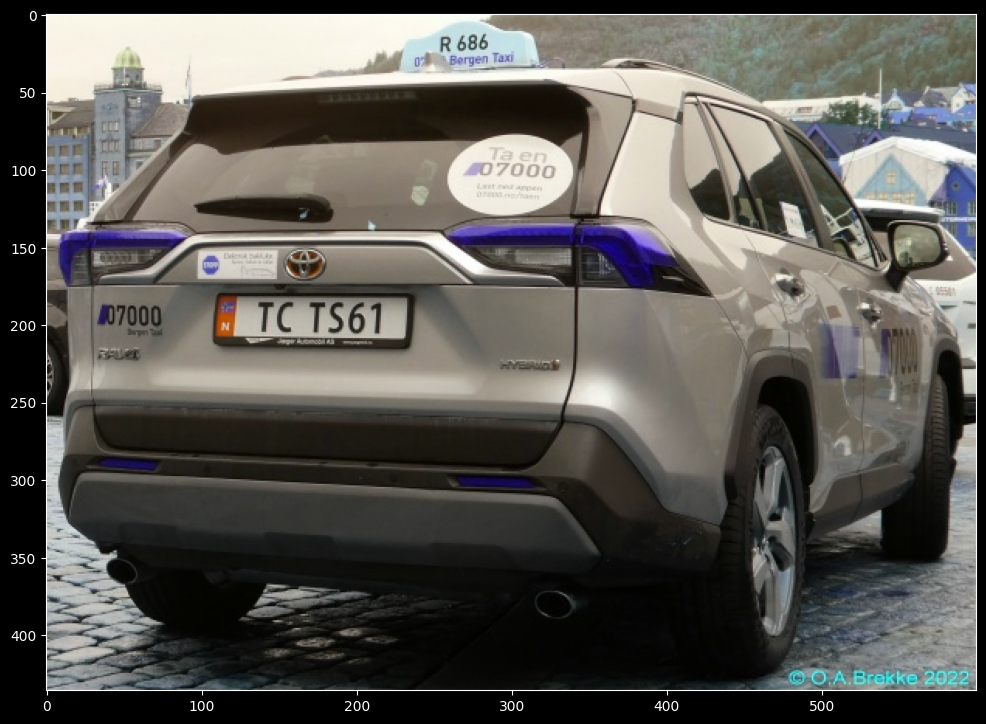

In [40]:
img = cv2.imread('img4.jpg')

height, width, channel = img.shape

plt.figure(figsize=(12, 10))
plt.imshow(img, cmap='gray')

Visualizing Image in Grayscale

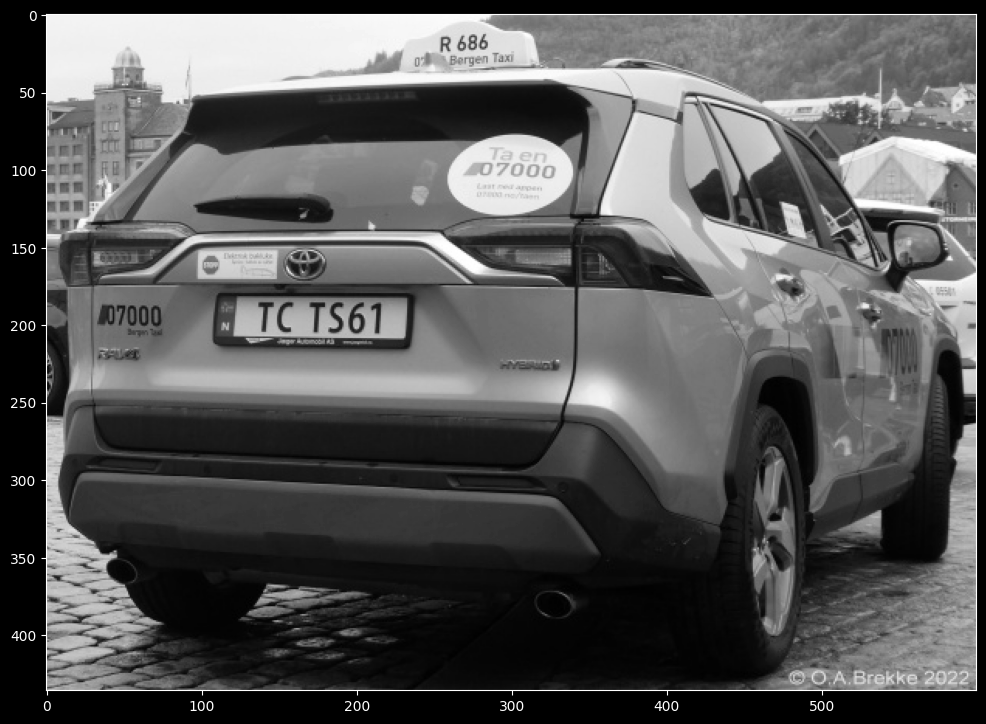

In [41]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap='gray')

Enhancing Grayscale Image

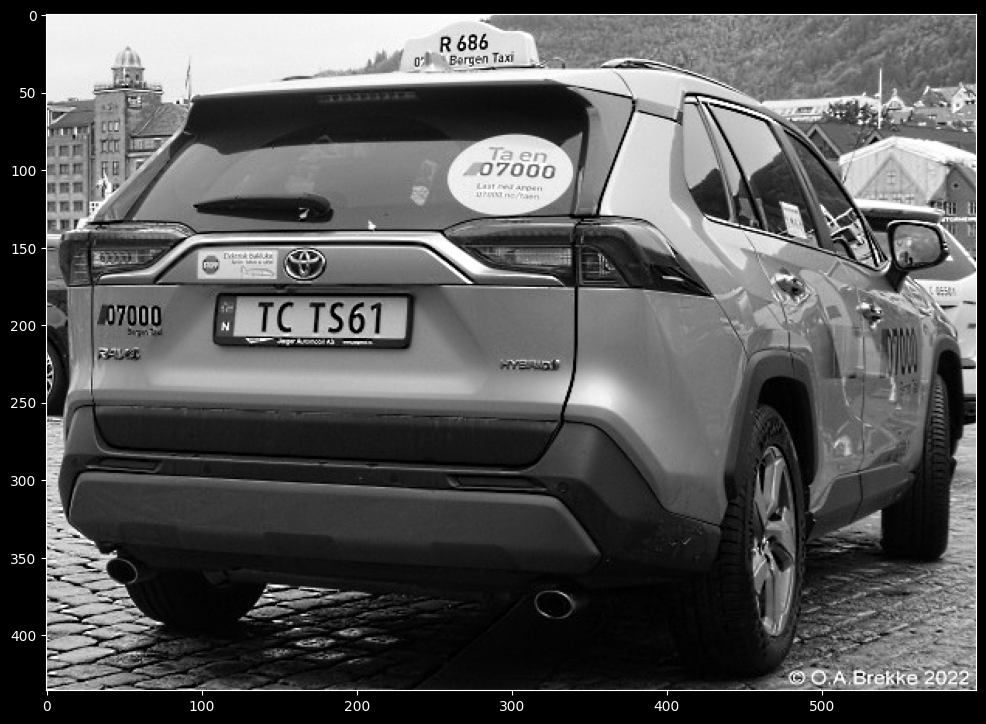

In [42]:
# Define a structuring element (kernel) for morphological operations
structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

imgTopHat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, structuringElement)
imgBlackHat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, structuringElement)

# Enhance the grayscale image using the results of morphological operations
imgGrayScaleTopHat = cv2.add(gray, imgTopHat)
gray = cv2.subtract(imgGrayScaleTopHat, imgBlackHat)

plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap='gray')


Image Preprocessing with Gaussian Blur and Adaptive Thresholding

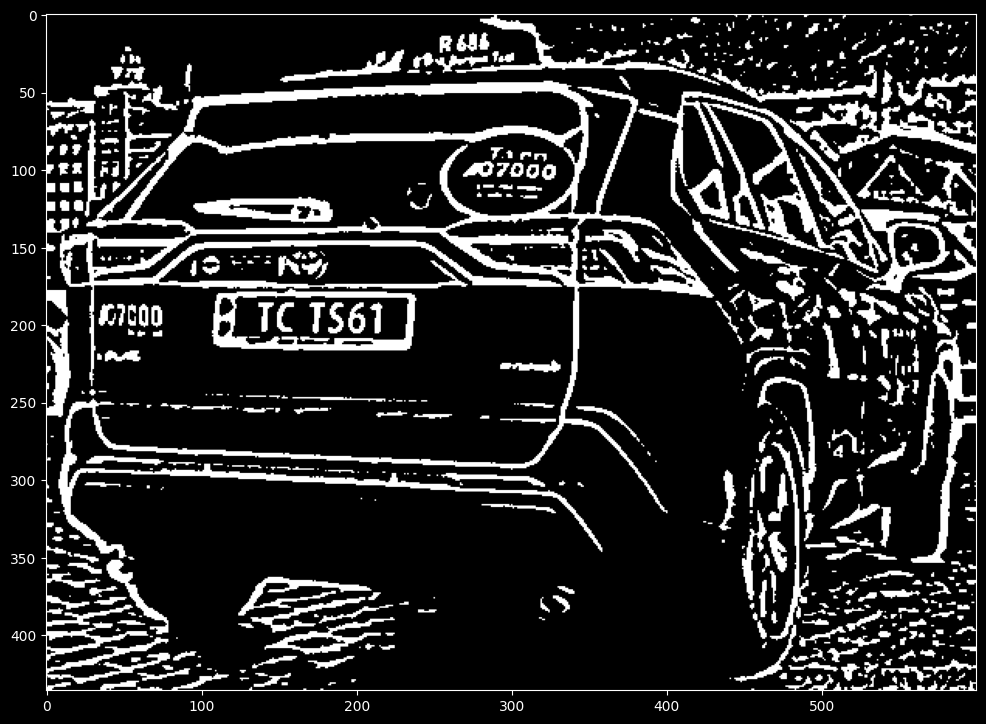

In [43]:
# Apply Gaussian blur to reduce noise and smooth the image
img_blur = cv2.GaussianBlur(gray, ksize=(5, 5), sigmaX=0)

# Apply adaptive thresholding to the blurred image
img_thresh = cv2.adaptiveThreshold(
    img_blur, 
    maxValue=255.0, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=19, 
    C=9
)

plt.figure(figsize=(12, 10))
plt.imshow(img_thresh, cmap='gray')

Drawing Contours

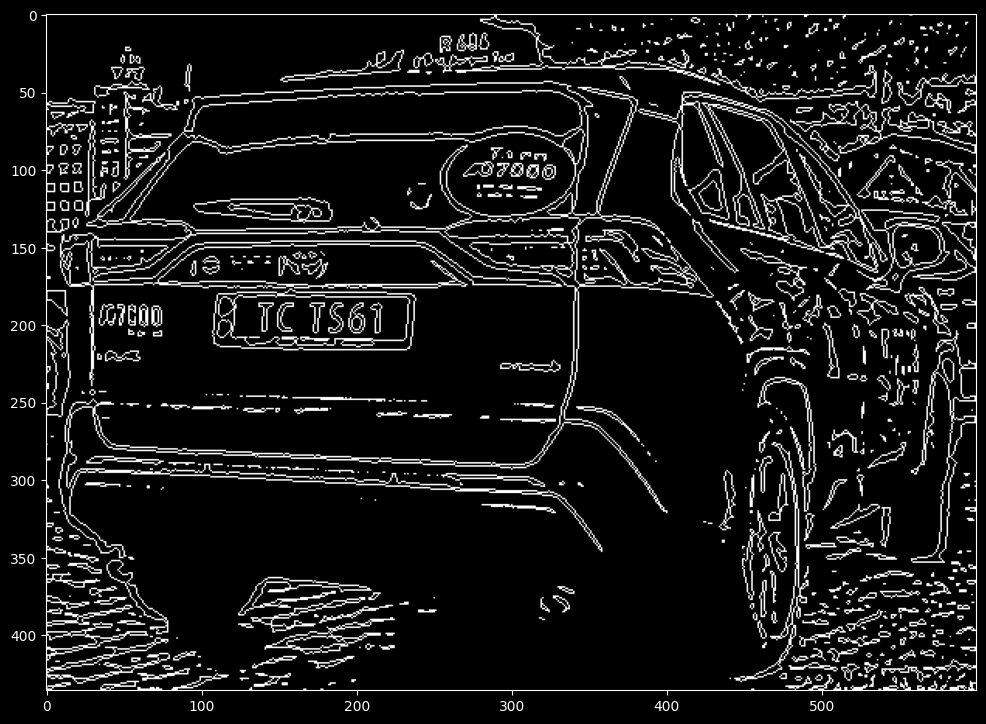

In [44]:
# Find contours in the thresholded image
contours, _ = cv2.findContours(
    img_thresh, 
    mode=cv2.RETR_LIST, 
    method=cv2.CHAIN_APPROX_SIMPLE
)
# Create a blank image for visualizing contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

# Draw all detected contours on the blank image
cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255, 255, 255))

plt.figure(figsize=(12, 10))
plt.imshow(temp_result)

Drawing Bounding Rectangles Around Contours and Storing Their Properties

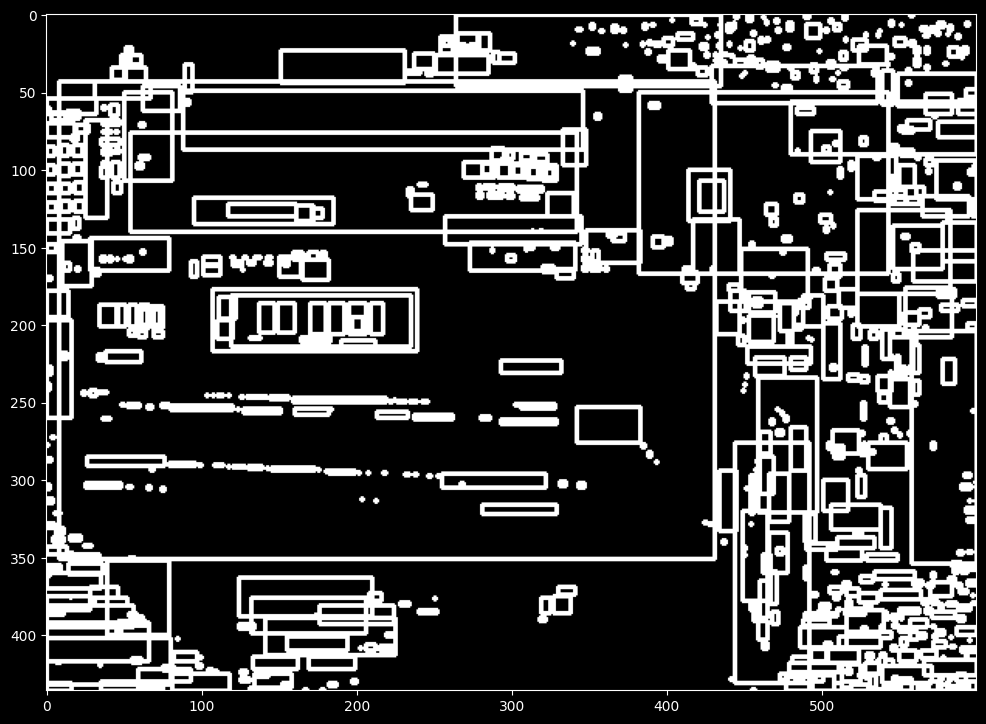

In [45]:
# Create a blank image for drawing rectangles
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

# Initialize an empty list to store contour properties
contours_dict = []

# Loop through each contour to calculate its bounding rectangle
for contour in contours:
    # Calculate the bounding rectangle for the contour
    x, y, w, h = cv2.boundingRect(contour)

    # Draw the bounding rectangle on the image
    cv2.rectangle(temp_result, pt1=(x, y), pt2=(x+w, y+h), color=(255, 255, 255), thickness=2)
    
    # Store contour properties in a dictionary
    contours_dict.append({
        'contour': contour,
        'x': x,
        'y': y,
        'w': w,
        'h': h,
        # Calculate the center coordinates of the rectangle
        'cx': x + (w / 2),
        'cy': y + (h / 2)
    })

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

Visualizing Potential License Plate Characters

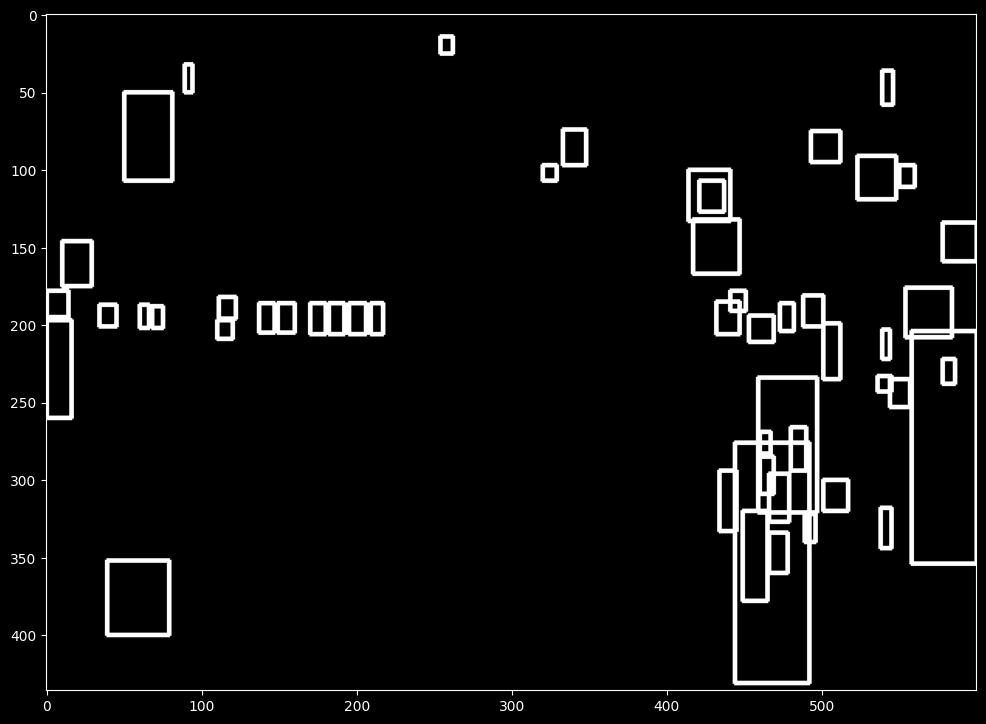

In [46]:
# Define constraints for contour size and aspect ratio
MIN_AREA = 80
MIN_WID, MIN_HEI = 2, 8
MIN_RATIO, MAX_RATIO = 0.25, 1.0

# Initialize a list to store valid contours
possible_contours = []

cnt = 0
for d in contours_dict:
    # Calculate area and aspect ratio of the contour
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']
    
    # Check if the contour meets the constraints
    if area > MIN_AREA \
    and d['w'] > MIN_WID and d['h'] > MIN_HEI \
    and MIN_RATIO < ratio < MAX_RATIO:
        # Assign an index to the contour
        d['idx'] = cnt
        cnt += 1
        possible_contours.append(d)
        
# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for d in possible_contours:
    # Draw bounding rectangles around the filtered contours
    cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

Identifying License Plate Candidates Using Recursive Contour Matching

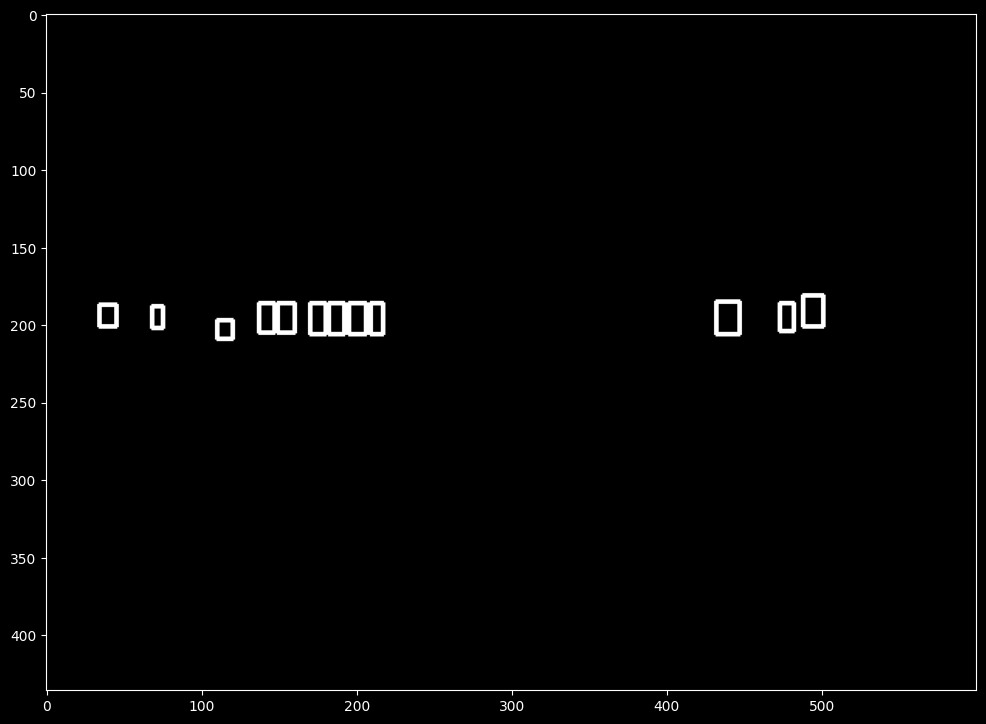

In [47]:
# Define parameters for contour comparison
MAX_DIAG_MULTIPLYER = 5 
MAX_ANGLE_DIFF = 12.0 
MAX_AREA_DIFF = 0.5 
MAX_WIDTH_DIFF = 0.8
MAX_HEIGHT_DIFF = 0.2
MIN_N_MATCHED = 3 # Minimum number of contours required for a valid license plate

# Recursive function to find matching contour groups
def find_chars(contour_list):
    matched_result_idx = []
    
    for d1 in contour_list:
        matched_contours_idx = []
        for d2 in contour_list:
            if d1['idx'] == d2['idx']:
                continue
            
            # Calculate distance and angle between d1 and d2
            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])

            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2)

            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))

            # Calculate angle difference
            if dx == 0:
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy / dx))
            
            # Calculate area, width, and height differences
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
            width_diff = abs(d1['w'] - d2['w']) / d1['w']
            height_diff = abs(d1['h'] - d2['h']) / d1['h']

            # Check if the contours meet the constraints
            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx'])

        # Include d1 in the matched group
        matched_contours_idx.append(d1['idx'])

        # Ignore groups with fewer than the minimum required matches
        if len(matched_contours_idx) < MIN_N_MATCHED:
            continue

        matched_result_idx.append(matched_contours_idx)

       # Process unmatched contours
        unmatched_contour_idx = []
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx:
                unmatched_contour_idx.append(d4['idx'])

        unmatched_contour = np.take(possible_contours, unmatched_contour_idx)
        
        # Recursively find matching contours in unmatched contours
        recursive_contour_list = find_chars(unmatched_contour)
        
        for idx in recursive_contour_list:
            matched_result_idx.append(idx)

        break

    return matched_result_idx

# Apply the function to find potential license plate groups
result_idx = find_chars(possible_contours)

# Organize matched results for visualization
matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))

# Visualize the matched contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:
        #cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
        cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

Extracting and Rotating Potential License Plates from Contours

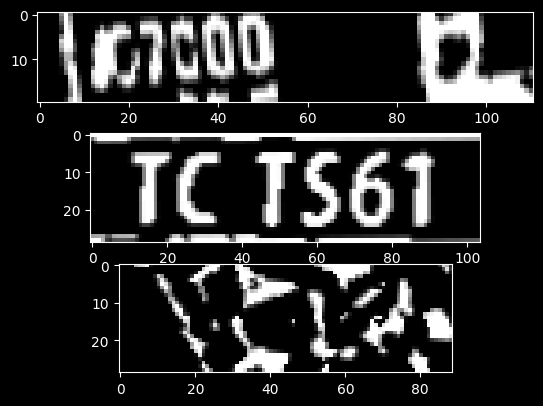

In [48]:
# Padding and ratio constraints for license plates
PLATE_WIDTH_PADDING = 1.3 
PLATE_HEIGHT_PADDING = 1.5
MIN_PLATE_RATIO = 2
MAX_PLATE_RATIO = 10

# Lists to store the extracted plate images and their metadata
plate_img = []
plate_infos = []

# Loop through each matched contour group
for i, matched_chars in enumerate(matched_result):
    # Sort characters by their x-coordinate to process them in order
    sorted_chars = sorted(matched_chars, key=lambda x: x['cx'])

    # Calculate the center and dimensions of the potential license plate
    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2
    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING
    
    # Calculate the average height of the characters
    sum_height = 0
    for d in sorted_chars:
        sum_height += d['h']
    plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)
    
    # Calculate the angle of rotation based on character alignment
    triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
    triangle_hypotenus = np.linalg.norm(
        np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) - 
        np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
    )
    
    angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus))
    
    # Rotate the image to align the plate horizontally
    rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle=angle, scale=1.0)
    img_rotated = cv2.warpAffine(img_thresh, M=rotation_matrix, dsize=(width, height))
    
    # Crop the rotated image to the plate's dimensions
    img_cropped = cv2.getRectSubPix(
        img_rotated, 
        patchSize=(int(plate_width), int(plate_height)), 
        center=(int(plate_cx), int(plate_cy))
    )
    
    # Filter out invalid plates based on aspect ratio
    if img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO or img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO > MAX_PLATE_RATIO:
        continue
    
    # Store the cropped plate image and its metadata
    plate_img.append(img_cropped)
    plate_infos.append({
        'x': int(plate_cx - plate_width / 2),
        'y': int(plate_cy - plate_height / 2),
        'w': int(plate_width),
        'h': int(plate_height)
    })
    
    plt.subplot(len(matched_result), 1, i+1)
    plt.imshow(img_cropped, cmap='gray')

Recognizing License Plate Characters with OCR

MENU
TC7561

Final selected plate(s): ['MENU', 'TC7561']


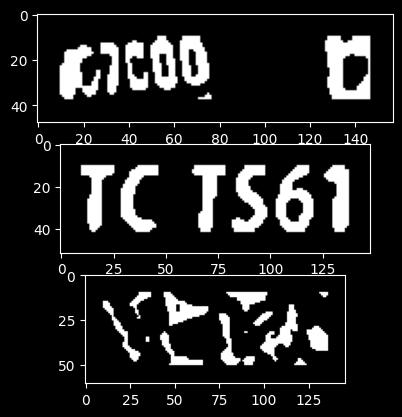

In [49]:
# Initialize variables to store the results
longest_idx, longest_text = -1, 0
plate_chars = []

# Loop through the cropped license plate images
for i, plate_imgs in enumerate(plate_img):
    # Resize the plate image for better OCR accuracy
    plate_imgs = cv2.resize(plate_imgs, dsize=(0, 0), fx=1.6, fy=1.6)
    # Apply binary thresholding
    _, plate_imgs = cv2.threshold(plate_imgs, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # Find contours again (same as above)
    contours, _ = cv2.findContours(plate_imgs, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)
    
    plate_min_x, plate_min_y = plate_imgs.shape[1], plate_imgs.shape[0]
    plate_max_x, plate_max_y = 0, 0

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        area = w * h
        ratio = w / h

        if area > MIN_AREA \
        and w > MIN_WID and h > MIN_HEI \
        and MIN_RATIO < ratio < MAX_RATIO:
            if x < plate_min_x:
                plate_min_x = x
            if y < plate_min_y:
                plate_min_y = y
            if x + w > plate_max_x:
                plate_max_x = x + w
            if y + h > plate_max_y:
                plate_max_y = y + h
                
    # Crop the valid region containing characters
    img_result = plate_imgs[plate_min_y:plate_max_y, plate_min_x:plate_max_x]
    
    # Apply Gaussian blur and binary thresholding to refine the result
    img_result = cv2.GaussianBlur(img_result, ksize=(3, 3), sigmaX=0)
    _, img_result = cv2.threshold(img_result, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # Add padding around the cropped region
    img_result = cv2.copyMakeBorder(img_result, top=10, bottom=10, left=10, right=10, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))

    # Use Tesseract OCR to extract text from the processed image
    chars = tess.image_to_string(img_result, lang='eng', config='--psm 7 --oem 0')
    
    # Filter out invalid characters
    result_chars = ''
    has_digit = False
    for c in chars:
        if ord('A') <= ord(c) <= ord('Z') or c.isdigit():
            if c.isdigit():
                has_digit = True
            result_chars += c
    
    # Print the recognized characters for debugging
    print(result_chars)
    plate_chars.append(result_chars)

    # Update the longest plate text if it contains digits and is longer
    if has_digit and len(result_chars) > longest_text:
        longest_idx = i

    plt.subplot(len(plate_img), 1, i+1)
    plt.imshow(img_result, cmap='gray')

final_plate = [plate for plate in plate_chars if len(plate) > 3]
print("Final selected plate(s):", final_plate)